In [ ]:
import os
import sys
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from pandarallel import pandarallel
import matplotlib.pyplot as plt
sys.path.append('../')
from utils import normalize_image, plot_image, plot_images

## Get image level labels

In [18]:
root_dir = '/data2/jupiter/datasets/OpenImages'

# load label csv
split = 'train'  # train, validation, test
# label_csv = os.path.join(root_dir, 'annotations', f'oidv5-{split}-annotations-human-imagelabels-boxable.csv')
label_csv = os.path.join(root_dir, 'annotations', f'oidv7-{split}-annotations-human-imagelabels.csv')
# image_ids = os.listdir(os.path.join(root_dir, split))
# image_ids = [f[:-4] for f in image_ids]
# np.savetxt(os.path.join(root_dir, 'annotations', f'{split}_saved.txt'), image_ids, delimiter='\n', fmt='%s')
image_ids = list(np.loadtxt(os.path.join(root_dir, 'annotations', f'{split}_saved.txt'), delimiter='\n', dtype=str))
df = pd.read_csv(label_csv)
print('# saved images', len(image_ids), 'loaded from csv', df.shape)

# load class description
description_csv = os.path.join(root_dir, 'annotations', 'oidv7-class-descriptions.csv')
description_df = pd.read_csv(description_csv)
description_dict = dict(zip(description_df.LabelName, description_df.DisplayName))
print(description_df.shape, len(description_dict))

# load trainable classes
trainable_txt = os.path.join(root_dir, 'annotations', 'oidv7-classes-trainable.txt')
with open(trainable_txt, 'r') as f:
    trainable_class_ids = f.readlines()
    trainable_class_ids = {s[:-1] for s in trainable_class_ids}
print('trainable classes', len(trainable_class_ids))

# load 600 boxable classes
boxable_classes_csv = os.path.join(root_dir, 'annotations', 'oidv7-class-descriptions-boxable.csv')
boxable_classes_df = pd.read_csv(boxable_classes_csv)
print('boxable classes', boxable_classes_df.shape)

# merge class description and trainable info
df = df.merge(description_df, on='LabelName', how='left')
df['Trainable'] = df['LabelName'].apply(lambda l: True if l in trainable_class_ids else False)
print(df.shape, len(df.ImageID.unique()))

# get trainable and boxable df
df_use = df[(df.DisplayName.isin(boxable_classes_df.DisplayName)) & (df.Trainable == True) & (df.Confidence > 0.0) & (df.ImageID.isin(image_ids))]
print(df_use.shape, len(df_use.ImageID.unique()))

# saved images 1743042 loaded from csv (58783034, 4)
(20931, 2) 20931
trainable classes 9668
boxable classes (601, 2)
(58783034, 6) 7337077
(7186825, 6) 1742623


In [15]:
df_use.head(10)

,ImageID,Source,LabelName,Confidence,DisplayName,Trainable
11,0001eeaf4aed83f9,crowdsource-verification,/m/0cmf2,1.0,Fixed-wing aircraft,True
29,000595fe6fee6369,verification,/m/02wbm,1.0,Food,True
30,000595fe6fee6369,crowdsource-verification,/m/02xwb,1.0,Fruit,True
37,000595fe6fee6369,crowdsource-verification,/m/07j7r,1.0,Tree,True
49,00075905539074f2,verification,/m/02p0tk3,1.0,Human body,True
51,00075905539074f2,verification,/m/04rky,1.0,Mammal,True
52,00075905539074f2,verification,/m/04yx4,1.0,Man,True
53,00075905539074f2,verification,/m/05y5lj,1.0,Sports equipment,True
54,00075905539074f2,verification,/m/09j2d,1.0,Clothing,True
55,00075905539074f2,verification,/m/09j5n,1.0,Footwear,True


In [58]:
import torch 
output = torch.randn(1, 86)
target = torch.ones(1, 86)

def accuracy(output, target, topk=(1,)):
    topk_index = {1: [53, 11, 81, 85, 61, 43, 78, 56, 17, 60], 5: [43, 78, 56, 17, 60]}  # top 10 and 5 classes
    output = torch.sigmoid(output)
    correct = (output > 0.5).eq(target)
    return [correct[:, topk_index[k]].sum() / len(topk_index[k]) / target.size(0) * 100 for k in topk]

# def accuracy(output, target, topk=(1,)):
#     """Computes the accuracy over the k top predictions for the specified values of k"""
#     maxk = min(max(topk), output.size()[1])
#     batch_size = target.size(0)
#     print(maxk, batch_size)
#     _, pred = output.topk(maxk, 1, True, True)
#     print(pred.shape)
#     pred = pred.t()
#     print(pred.shape)
#     correct = pred.eq(target.reshape(1, -1).expand_as(pred))
#     return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

accuracy(output, target, topk=(1,5))

[tensor(20.), tensor(20.)]

In [3]:
# # convert classes to binary labels in a row
# df_use2 = pd.DataFrame(data={'ImageID': list(df_use.ImageID.unique())})
# print(df_use2.shape)

# # group by image id
# g = dict(iter(df_use.groupby('ImageID')))
# print(len(g))

# # get boxable class list
# boxable_classes = boxable_classes_df.DisplayName.to_list()
# print(len(boxable_classes))

# def get_binary_label(row, g, boxable_classes):
#     names = g[row.ImageID].DisplayName.to_list()
#     for c in boxable_classes:
#         row[c] = 1.0 if c in names else 0.0
#     return row

# pandarallel.initialize(nb_workers=16, progress_bar=True)
# df_use2 = df_use2.parallel_apply(lambda row: get_binary_label(row, g, boxable_classes), axis=1)
# print(df_use2.shape)
# df_use2.to_csv(os.path.join(root_dir, 'annotations', f'{split}_600classes.csv'), index=False)

root_dir = '/data2/jupiter/datasets/OpenImages'
split = 'train'
df_use2 = pd.read_csv(os.path.join(root_dir, 'annotations', f'{split}_600classes.csv'))
df_use2.shape

(1742623, 602)

In [4]:
df_use2.head(3)

,ImageID,Accordion,Adhesive tape,Aircraft,Alarm clock,Alpaca,Ambulance,Animal,Ant,Antelope,...,Wine rack,Winter melon,Wok,Woman,Wood-burning stove,Woodpecker,Worm,Wrench,Zebra,Zucchini
0,000002b66c9c498e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000002b97e5471a0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000002c707c9895e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
df_use3 = df_use2[['ImageID'] + cc_df.DisplayName.to_list()]
print(df_use3.shape)
# df_use3['sum'] = df_use3.apply(lambda row: row.values[1:].astype(np.float32).sum(), axis=1)
# print(df_use3.shape)
# df_use3_empty = df_use3[df_use3['sum'] == 0.0]
# df_use3_empty.shape

(1742623, 87)
(1742623, 88)


In [86]:
df_use3_empty.sample(3).ImageID.to_list()

['1f850847ce446bda', '04e96a242fd3ee7a', '8be971af85ca5ab7']

570
570 570
(570, 2)


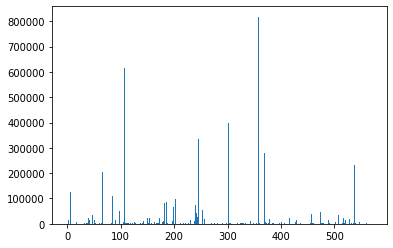

In [21]:
# get distribution of boxable classes
g = df_use[['DisplayName', 'ImageID']].groupby('DisplayName')
print(len(g))

names, counts = [], []
for name, group in g:
    names.append(name)
    counts.append(len(group))
print(len(names), len(counts))

class_count_df = pd.DataFrame(data={'DisplayName': names, 'Count': counts})
print(class_count_df.shape)

plt.bar(range(len(names)), counts)
plt.show()

(86, 2)


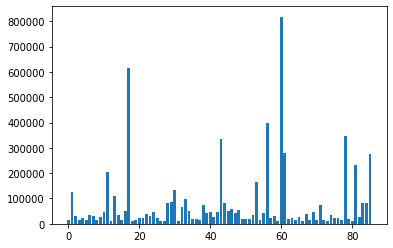

In [5]:
# class_count_df.to_csv(os.path.join(root_dir, 'annotations', 'train_class_count.csv'), index=False)
class_count_df = pd.read_csv(os.path.join(root_dir, 'annotations', 'train_class_count.csv'))
cc_df = class_count_df[class_count_df.Count > 10000]

print(cc_df.shape)

plt.bar(range(len(cc_df)), cc_df.Count)
plt.show()

In [7]:
# get index of top 10 classes of 86
counts = np.array(cc_df.Count.to_list())
index = np.argsort(counts)
# get index of top 10 classes of 86
k = 10
print(index[-k:], counts[index[-k:]], sum(counts[index[-k:]]) / sum(counts))
# get index of last 10 classes of 86
print(index[:k], counts[index[:k]], sum(counts[index[:k]]) / sum(counts))

[53 11 81 85 61 43 78 56 17 60] [165525 204200 230944 275305 278390 333119 345303 396932 614635 818202] 0.569016068306382
[18 80 73 31 59 12 66 26 27 77] [10419 10599 10641 10715 10891 11041 11410 12033 12226 13332] 0.017603422652107945


In [8]:
counts

array([ 14459, 124532,  30020,  14740,  23768,  15633,  36324,  29862,
        15221,  25161,  48468, 204200,  11041, 108339,  35969,  14132,
        49917, 614635,  10419,  14355,  23396,  23079,  39954,  30058,
        48443,  21063,  12033,  12226,  81634,  85845, 135123,  10715,
        68242,  96838,  51337,  18319,  18472,  14344,  73148,  42394,
        45953,  28699,  47557, 333119,  81540,  51293,  56961,  41266,
        54568,  18842,  20554,  18775,  33661, 165525,  15036,  41544,
       396932,  24167,  31689,  10891, 818202, 278390,  20715,  21918,
        16444,  25164,  11410,  38852,  13397,  45825,  15825,  73709,
        16110,  10641,  34175,  22908,  23080,  13332, 345303,  19639,
        10599, 230944,  26787,  80556,  80986, 275305])

In [13]:
pos_weight = counts.max() / counts
pos_weight = (pos_weight - 1.0) / 8.0 + 1.0
pos_weight.astype(np.uint8)

array([ 7,  1,  4,  7,  5,  7,  3,  4,  7,  4,  2,  1, 10,  1,  3,  8,  2,
        1, 10,  7,  5,  5,  3,  4,  2,  5,  9,  9,  2,  2,  1, 10,  2,  1,
        2,  6,  6,  8,  2,  3,  3,  4,  3,  1,  2,  2,  2,  3,  2,  6,  5,
        6,  3,  1,  7,  3,  1,  5,  4, 10,  1,  1,  5,  5,  7,  4,  9,  3,
        8,  3,  7,  2,  7, 10,  3,  5,  5,  8,  1,  6, 10,  1,  4,  2,  2,
        1], dtype=uint8)

In [33]:
# # load boxable classes
# boxable_classes_json = os.path.join(root_dir, 'annotations', 'bbox_labels_600_hierarchy.json')
# with open(boxable_classes_json, 'r') as f:
#     boxable_classes = json.load(f)
# print(len(boxable_classes))

# def get_sub_categories(d, description_dict, flat_names, end_names):
#     LabelName = description_dict.get(d['LabelName'], 'total')
#     sub_categories = {}
#     flat_names.append(LabelName)
#     if 'Subcategory' in d:
#         for d2 in d['Subcategory']:
#             sub_categories.update(get_sub_categories(d2, description_dict, flat_names, end_names))
#     else:
#         end_names.append(LabelName)
#     return {LabelName: sub_categories}

# boxable_classes_flat, boxable_classes_end = [], []
# boxable_classes_dict = get_sub_categories(boxable_classes, description_dict, boxable_classes_flat, boxable_classes_end)
# boxable_classes_flat = boxable_classes_flat[1:]
# print(len(boxable_classes_dict), len(boxable_classes_flat), len(boxable_classes_end))

1 670 590


In [24]:
image_ids[:10]

['4b8ce17909ce1bd7.jpg',
 '015f5cd905204962.jpg',
 'c310d709fbef6597.jpg',
 'd6ed7aec7b1a73b9.jpg',
 '8e2707ebf993b75e.jpg',
 '023a8d0a05ec58ad.jpg',
 'a0bcf2713a3dd5bb.jpg',
 '25a8fd3bf02dba27.jpg',
 '75d9c19761664f1e.jpg',
 '1028befe2a3de8ad.jpg']

In [95]:
id = '8be971af85ca5ab7'
df2 = df[df.ImageID == id]
print(df2.shape)
df2.sample(10)

(23, 6)


,ImageID,Source,LabelName,Confidence,DisplayName,Trainable
47725890,8be971af85ca5ab7,verification,/m/0314qb,0.0,Cucumber sandwich,False
47725895,8be971af85ca5ab7,crowdsource-verification,/m/06fvc,1.0,Red,True
47725900,8be971af85ca5ab7,verification,/m/08fw1g,0.0,Food group,True
47725892,8be971af85ca5ab7,verification,/m/040dsb,0.0,Cucumis,True
47725896,8be971af85ca5ab7,verification,/m/0785_l,0.0,Figleaf gourd,False
47725894,8be971af85ca5ab7,verification,/m/069dmg,0.0,Bánh bao,True
47725903,8be971af85ca5ab7,verification,/m/0dqb5,0.0,Citrus,True
47725886,8be971af85ca5ab7,verification,/m/021fl7,0.0,Pomelo,True
47725889,8be971af85ca5ab7,verification,/m/02qq0s,0.0,Saltwater crocodile,True
47725899,8be971af85ca5ab7,verification,/m/08b4k2,1.0,Honeydew,True


8be971af85ca5ab7 (768, 1024, 3)


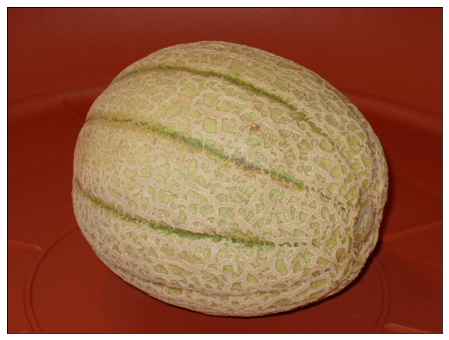

In [96]:
image_path = os.path.join(root_dir, split, id+'.jpg')
image = imageio.imread(image_path)
print(id, image.shape)
plot_image(image)

In [97]:
boxable_classes = boxable_classes_df.DisplayName.to_list()
print(df2[(df2.Confidence < 0.5) & (df2.DisplayName.isin(boxable_classes))].DisplayName.to_list())
print(df2[(df2.Confidence > 0.5) & (df2.DisplayName.isin(boxable_classes))].DisplayName.to_list())
print(df2[df2.DisplayName.isin(cc_df.DisplayName)].DisplayName.to_list())

[]
['Cantaloupe']
[]


## Get segmentation labels

In [51]:
mask_ids = os.listdir(os.path.join(root_dir, 'masks_raw', split))
np.savetxt(os.path.join(root_dir, 'masks_raw', f'{split}_mask_saved.txt'), mask_ids, delimiter='\n', fmt='%s')

In [52]:
root_dir = '/data2/jupiter/datasets/OpenImages'

# load label csv
split = 'train'  # train, validation, test
label_csv = os.path.join(root_dir, 'masks_raw', f'{split}-annotations-object-segmentation.csv')
# image_ids = os.listdir(os.path.join(root_dir, split))
# image_ids = [f[:-4] for f in image_ids]
# np.savetxt(os.path.join(root_dir, 'annotations', f'{split}_saved.txt'), image_ids, delimiter='\n', fmt='%s')
image_ids = list(np.loadtxt(os.path.join(root_dir, 'annotations', f'{split}_saved.txt'), delimiter='\n', dtype=str))
# mask_ids = os.listdir(os.path.join(root_dir, 'masks_raw', split))
# np.savetxt(os.path.join(root_dir, 'masks_raw', f'{split}_mask_saved.txt'), mask_ids, delimiter='\n', fmt='%s')
mask_ids = list(np.loadtxt(os.path.join(root_dir, 'masks_raw', f'{split}_mask_saved.txt'), delimiter='\n', dtype=str))
df = pd.read_csv(label_csv)
print('# saved images', len(image_ids), '# saved masks', len(mask_ids), 'loaded from csv', df.shape)

# load class description
description_csv = os.path.join(root_dir, 'annotations', 'oidv7-class-descriptions.csv')
description_df = pd.read_csv(description_csv)
description_dict = dict(zip(description_df.LabelName, description_df.DisplayName))
print('class description', description_df.shape, len(description_dict))

# load trainable classes
trainable_txt = os.path.join(root_dir, 'annotations', 'oidv7-classes-trainable.txt')
with open(trainable_txt, 'r') as f:
    trainable_class_ids = f.readlines()
    trainable_class_ids = {s[:-1] for s in trainable_class_ids}
print('trainable classes', len(trainable_class_ids))

# load 600 boxable classes
boxable_classes_csv = os.path.join(root_dir, 'annotations', 'oidv7-class-descriptions-boxable.csv')
boxable_classes_df = pd.read_csv(boxable_classes_csv)
print('boxable classes', boxable_classes_df.shape)

# merge class description and trainable info
df = df.merge(description_df, on='LabelName', how='left')
df['Trainable'] = df['LabelName'].apply(lambda l: True if l in trainable_class_ids else False)
print(df.shape, len(df.ImageID.unique()))

# get trainable and boxable df
df_use = df[(df.DisplayName.isin(boxable_classes_df.DisplayName)) & (df.Trainable == True) & (df.ImageID.isin(image_ids)) & (df.MaskPath.isin(mask_ids))]
print(df_use.shape, len(df_use.ImageID.unique()))

# saved images 1743042 # saved masks 932943 loaded from csv (2686666, 10)
class description (20931, 2) 20931
trainable classes 9668
boxable classes (601, 2)
(2686666, 12) 944037
(911132, 12) 326219


In [65]:
df[(df.ImageID.isin(image_ids)) & (df.MaskPath.isin(mask_ids))].shape

(911335, 12)

In [53]:
df.head()

,MaskPath,ImageID,LabelName,BoxID,BoxXMin,BoxXMax,BoxYMin,BoxYMax,PredictedIoU,Clicks,DisplayName,Trainable
0,677c122b0eaa5d16_m04yx4_9a041d52.png,677c122b0eaa5d16,/m/04yx4,9a041d52,0.887500,0.960938,0.454167,0.720833,0.86864,0.95498 0.65197 1;0.89370 0.56579 1;0.94701 0....,Man,True
1,05529ae018130c68_m09j2d_b1115fd0.png,05529ae018130c68,/m/09j2d,b1115fd0,0.086875,0.254375,0.504708,0.790960,0.80250,0.16388 0.50114 1;0.25069 0.75425 1;0.13478 0....,Clothing,True
2,96e7ee70b428a54e_m04yx4_05580497.png,96e7ee70b428a54e,/m/04yx4,05580497,0.456250,0.603125,0.222013,0.903104,0.55850,0.52271 0.46625 0;0.52695 0.70150 0;0.59151 0....,Man,True
3,76084f166740d78a_m09j2d_557dfcf5.png,76084f166740d78a,/m/09j2d,557dfcf5,0.018750,0.145625,0.313333,0.754167,0.62394,0.08756 0.34082 0;0.03971 0.34195 1;0.06705 0....,Clothing,True
4,ebaccfc70c721055_m02p0tk3_b39109c0.png,ebaccfc70c721055,/m/02p0tk3,b39109c0,0.097500,0.212500,0.291667,0.930833,0.84223,0.19847 0.85413 1;0.18916 0.34751 1;0.18636 0....,Human body,True


In [54]:
df_use.head()

,MaskPath,ImageID,LabelName,BoxID,BoxXMin,BoxXMax,BoxYMin,BoxYMax,PredictedIoU,Clicks,DisplayName,Trainable
1,05529ae018130c68_m09j2d_b1115fd0.png,05529ae018130c68,/m/09j2d,b1115fd0,0.086875,0.254375,0.504708,0.790960,0.80250,0.16388 0.50114 1;0.25069 0.75425 1;0.13478 0....,Clothing,True
6,117e9ecb4620b5c2_m04yx4_8698d30f.png,117e9ecb4620b5c2,/m/04yx4,8698d30f,0.700000,0.984667,0.222000,0.999000,0.89637,0.93971 0.44178 0;0.72594 0.75974 1;0.75367 0....,Man,True
7,3dd17c63d66af596_m083wq_c4a4c83f.png,3dd17c63d66af596,/m/083wq,c4a4c83f,0.170898,0.441406,0.242188,0.579427,0.52503,0.18024 0.38744 1;0.32056 0.39748 0;0.42371 0....,Wheel,True
9,0cc813cd543a777d_m083wq_79231d5d.png,0cc813cd543a777d,/m/083wq,79231d5d,0.853125,0.999375,0.777500,0.999167,0.40785,0.96512 0.81480 0;0.87749 0.82339 1;0.88136 0....,Wheel,True
12,141fc01d016a36ac_m0fszt_71d4ffad.png,141fc01d016a36ac,/m/0fszt,71d4ffad,0.296875,0.481250,0.692187,0.851562,0.91637,0.38561 0.69866 1;0.42108 0.84442 1;0.46821 0....,Cake,True


In [55]:
len(df.DisplayName.unique()), len(df_use.DisplayName.unique())

(350, 329)

In [76]:
sub_df = df_use[['ImageID', 'DisplayName']]
sub_df.drop_duplicates(inplace=True)
sub_df.shape

(472389, 2)

329
329 329
(329, 2)


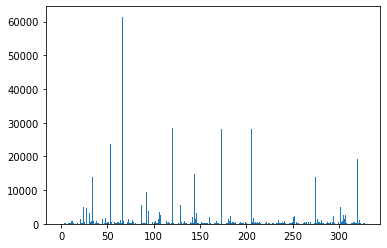

In [77]:
# get distribution of boxable classes
g = sub_df[['DisplayName', 'ImageID']].groupby('DisplayName')
print(len(g))

names, counts = [], []
for name, group in g:
    names.append(name)
    counts.append(len(group))
print(len(names), len(counts))

class_count_df = pd.DataFrame(data={'DisplayName': names, 'Count': counts})
print(class_count_df.shape)

plt.bar(range(len(names)), counts)
plt.show()

(57, 2)
{'Beer': 0, 'Bicycle wheel': 1, 'Bird': 2, 'Book': 3, 'Bottle': 4, 'Boy': 5, 'Bus': 6, 'Cake': 7, 'Camera': 8, 'Car': 9, 'Cat': 10, 'Christmas tree': 11, 'Clothing': 12, 'Coffee cup': 13, 'Computer keyboard': 14, 'Couch': 15, 'Dog': 16, 'Dress': 17, 'Drink': 18, 'Duck': 19, 'Fish': 20, 'Fixed-wing aircraft': 21, 'Flag': 22, 'Flower': 23, 'Flowerpot': 24, 'Girl': 25, 'Guitar': 26, 'Hat': 27, 'Horse': 28, 'Human body': 29, 'Human ear': 30, 'Human mouth': 31, 'Jeans': 32, 'Laptop': 33, 'Man': 34, 'Mobile phone': 35, 'Motorcycle': 36, 'Person': 37, 'Picture frame': 38, 'Rose': 39, 'Sculpture': 40, 'Shirt': 41, 'Shorts': 42, 'Skyscraper': 43, 'Suit': 44, 'Sun hat': 45, 'Swimwear': 46, 'Tie': 47, 'Toy': 48, 'Train': 49, 'Trousers': 50, 'Truck': 51, 'Van': 52, 'Vehicle registration plate': 53, 'Wheel': 54, 'Wine': 55, 'Woman': 56}


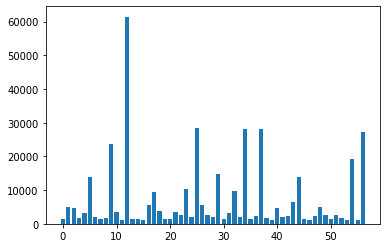

In [90]:
# class_count_df.to_csv(os.path.join(root_dir, 'masks', 'train_class_count.csv'), index=False)
# class_count_df = pd.read_csv(os.path.join(root_dir, 'masks', 'train_class_count.csv'))
cc_df = class_count_df[class_count_df.Count > 1000]
class_id_map = {cc_df.iloc[i].DisplayName: i for i in range(len(cc_df))}

print(cc_df.shape)
print(class_id_map)

plt.bar(range(len(cc_df)), cc_df.Count)
plt.show()

In [91]:
# combine multiple instance masks into single mask
df_use2 = df_use[df_use.DisplayName.isin(class_id_map.keys())]
print(df_use2.shape, len(df_use2.ImageID.unique()))

(782814, 12) 271440


In [96]:
id = df_use2.sample(1).iloc[0].ImageID
sub_df = df_use2[df_use2.ImageID == id]
print(sub_df.shape)
sub_df

(5, 12)


,MaskPath,ImageID,LabelName,BoxID,BoxXMin,BoxXMax,BoxYMin,BoxYMax,PredictedIoU,Clicks,DisplayName,Trainable
376307,350d09e529bb1577_m0271t_beba1a24.png,350d09e529bb1577,/m/0271t,beba1a24,0.501876,0.712008,0.767500,0.999375,0.89068,0.65134 0.90752 0;0.55865 0.86141 0;0.69544 0....,Drink,True
736865,350d09e529bb1577_m09j2d_0e6333d0.png,350d09e529bb1577,/m/09j2d,0e6333d0,0.145403,0.925891,0.003750,0.832500,0.77119,0.87419 0.30504 0;0.28890 0.32557 0;0.39569 0....,Clothing,True
1171786,350d09e529bb1577_m0271t_55a9a6f1.png,350d09e529bb1577,/m/0271t,55a9a6f1,0.709193,0.953096,0.740000,0.999375,0.74465,0.87413 0.92787 0;0.92517 0.84016 1;0.85734 0....,Drink,True
1818626,350d09e529bb1577_m0271t_2a14aea9.png,350d09e529bb1577,/m/0271t,2a14aea9,0.619137,0.811445,0.627500,0.781250,0.62051,0.69442 0.73970 1;0.75243 0.63142 0;0.74806 0....,Drink,True
2452467,350d09e529bb1577_m0271t_b2400340.png,350d09e529bb1577,/m/0271t,b2400340,0.261726,0.404315,0.735625,0.968125,0.53471,0.34909 0.78908 0;0.39050 0.81338 0;0.28110 0....,Drink,True


350d09e529bb1577 (1024, 683, 3)


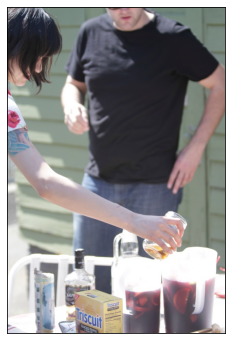

Drink (1600, 1066)


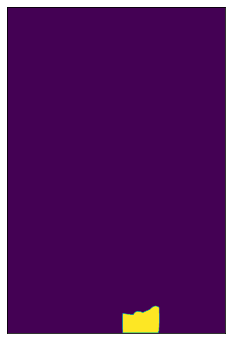

Clothing (1600, 1066)


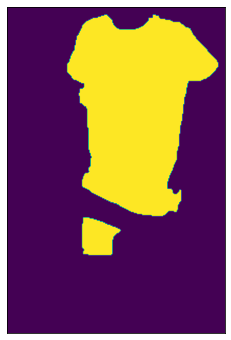

Drink (1600, 1066)


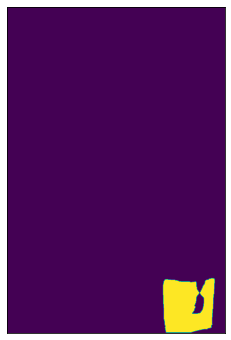

Drink (1600, 1066)


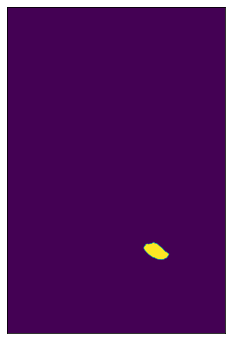

Drink (1600, 1066)


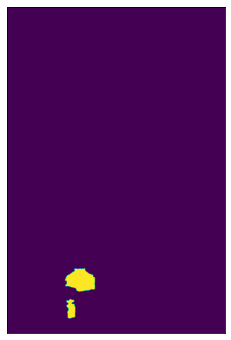

In [97]:
image_path = os.path.join(root_dir, split, id+'.jpg')
image = imageio.imread(image_path)
print(id, image.shape)
plot_image(image)

mask_raw_dir = os.path.join(root_dir, 'masks_raw', split)
for i,row in sub_df.iterrows():
    mask_path = os.path.join(mask_raw_dir, row.MaskPath)
    if not os.path.isfile(mask_path):
        continue
    mask = imageio.imread(mask_path)
    print(row.DisplayName, mask.shape)
    plot_image(mask)

## Get image level labels for full dataset (9M)

In [2]:
root_dir = '/data3/jupiter/datasets/public_datasets/OpenImages/'

# load label csv
split = 'train'  # train, validation, test
label_csv = os.path.join(root_dir, 'meta_data', f'oidv7-{split}-annotations-human-imagelabels.csv')
# image_ids = os.listdir(os.path.join(root_dir, split))
# image_ids = [f[:-4] for f in image_ids]
# np.savetxt(os.path.join(root_dir, 'meta_data', f'{split}_saved.txt'), image_ids, delimiter='\n', fmt='%s')
image_ids = list(np.loadtxt(os.path.join(root_dir, 'meta_data', f'{split}_saved.txt'), dtype=str))
df = pd.read_csv(label_csv)
print('# saved images', len(image_ids), 'loaded from csv', df.shape)

# load class description
description_csv = os.path.join(root_dir, 'meta_data', 'oidv7-class-descriptions.csv')
description_df = pd.read_csv(description_csv)
description_dict = dict(zip(description_df.LabelName, description_df.DisplayName))
print(description_df.shape, len(description_dict))

# load trainable classes
trainable_txt = os.path.join(root_dir, 'meta_data', 'oidv7-classes-trainable.txt')
with open(trainable_txt, 'r') as f:
    trainable_class_ids = f.readlines()
    trainable_class_ids = {s[:-1] for s in trainable_class_ids}
print('trainable classes', len(trainable_class_ids))

# load 600 boxable classes
boxable_classes_csv = os.path.join(root_dir, 'meta_data', 'oidv7-class-descriptions-boxable.csv')
boxable_classes_df = pd.read_csv(boxable_classes_csv)
print('boxable classes', boxable_classes_df.shape)

# merge class description and trainable info
df = df.merge(description_df, on='LabelName', how='left')
df['Trainable'] = df['LabelName'].apply(lambda l: True if l in trainable_class_ids else False)
print(df.shape, len(df.ImageID.unique()))

# get trainable and boxable df
df_use = df[(df.DisplayName.isin(boxable_classes_df.DisplayName)) & (df.Trainable == True) & (df.Confidence > 0.0) & (df.ImageID.isin(image_ids))]
print(df_use.shape, len(df_use.ImageID.unique()))

# saved images 9010552 loaded from csv (58783034, 4)
(20931, 2) 20931
trainable classes 9668
boxable classes (601, 2)
(58783034, 6) 7337077
(10879941, 6) 4123676


In [3]:
df_use.head(10)

,ImageID,Source,LabelName,Confidence,DisplayName,Trainable
27,000002b66c9c498e,verification,/m/014sv8,1.0,Human eye,True
85,000002b66c9c498e,verification,/m/01bl7v,1.0,Boy,True
98,000002b66c9c498e,verification,/m/01d40f,1.0,Dress,True
108,000002b66c9c498e,verification,/m/01g317,1.0,Person,True
151,000002b66c9c498e,verification,/m/01mzpv,1.0,Chair,True
240,000002b66c9c498e,verification,/m/0270h,1.0,Dessert,True
241,000002b66c9c498e,verification,/m/0271t,1.0,Drink,True
250,000002b66c9c498e,verification,/m/0283dt1,1.0,Human mouth,True
251,000002b66c9c498e,verification,/m/0284d,1.0,Dairy Product,True
290,000002b66c9c498e,verification,/m/02p0tk3,1.0,Human body,True


In [4]:
# # convert classes to binary labels in a row
# df_use2 = pd.DataFrame(data={'ImageID': list(df_use.ImageID.unique())})
# print(df_use2.shape)

# # group by image id
# g = dict(iter(df_use.groupby('ImageID')))
# print(len(g))

# # get boxable class list
# boxable_classes = boxable_classes_df.DisplayName.to_list()
# print(len(boxable_classes))

# def get_binary_label(row, g, boxable_classes):
#     names = g[row.ImageID].DisplayName.to_list()
#     for c in boxable_classes:
#         row[c] = 1.0 if c in names else 0.0
#     return row

# pandarallel.initialize(nb_workers=14, progress_bar=True)
# df_use2 = df_use2.parallel_apply(lambda row: get_binary_label(row, g, boxable_classes), axis=1)
# print(df_use2.shape)
# df_use2.to_csv(os.path.join(root_dir, 'meta_data', f'{split}_600classes.csv'), index=False)

split = 'train'
df_use2 = pd.read_csv(os.path.join(root_dir, 'meta_data', f'{split}_600classes.csv'))
df_use2.shape

(4123676, 602)

570
570 570
(570, 2)


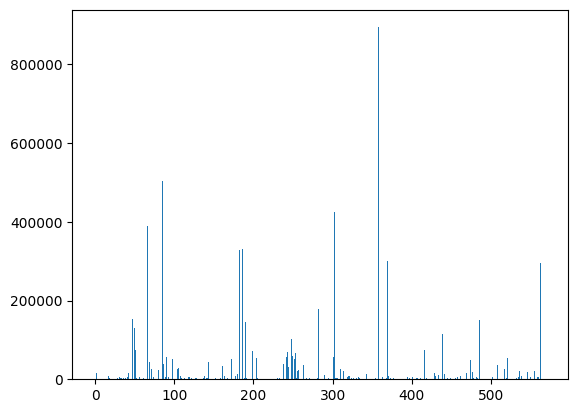

In [5]:
# get distribution of boxable classes
g = df_use[['DisplayName', 'ImageID']].groupby('DisplayName')
print(len(g))

names, counts = [], []
for name, group in g:
    names.append(name)
    counts.append(len(group))
print(len(names), len(counts))

class_count_df = pd.DataFrame(data={'DisplayName': names, 'Count': counts})
print(class_count_df.shape)

plt.bar(range(len(names)), counts)
plt.show()

(101, 2)


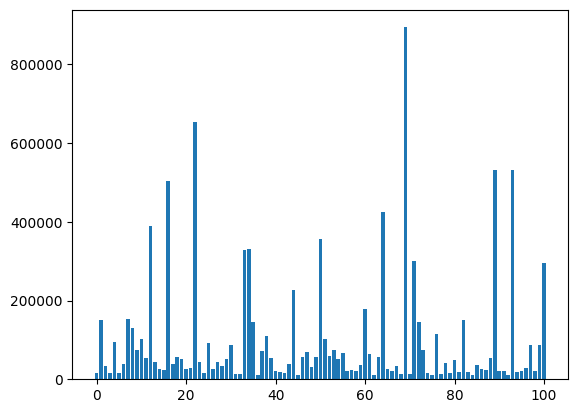

In [6]:
# class_count_df.to_csv(os.path.join(root_dir, 'meta_data', 'train_class_count.csv'), index=False)
class_count_df = pd.read_csv(os.path.join(root_dir, 'meta_data', 'train_class_count.csv'))
cc_df = class_count_df[class_count_df.Count > 10000]

print(cc_df.shape)

plt.bar(range(len(cc_df)), cc_df.Count)
plt.show()

## Download images using urls

In [50]:
# download images with urls
import requests
from pandarallel import pandarallel
def download_image(save_dir, row):
    file_path = os.path.join(save_dir, row['Subset'], row['ImageID']+'.jpg')
    need_download = False
    download_success = False
    if not os.path.isfile(file_path):
        need_download = True
    else:
        try:
            img = Image.open(file_path)  # file broken
        except:
            need_download = True
    if need_download:
        # try:
        # print(row['OriginalURL'])
        img_data = requests.get(row['OriginalURL'], timeout=3, headers={'User-agent': 'your bot 0.1'}).content
        with open(file_path, 'wb') as handler:
            handler.write(img_data)
        download_success = True
        # except:
        #     pass
    row['need_download'] = need_download
    row['download_success'] = download_success
    return row

In [2]:
save_dir = '/data3/jupiter/datasets/public_datasets/OpenImages'
csv_file = '/data3/jupiter/datasets/public_datasets/OpenImages/meta_data/image_ids_and_rotation.csv'
df = pd.read_csv(csv_file, low_memory=False)
print(df.shape)

(9178275, 12)


In [3]:
df.head(2)

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,4fa8054781a4c382,train,https://farm3.staticflickr.com/5310/5898076654...,https://www.flickr.com/photos/michael-beat/589...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/michael-beat/,Michael Beat,...die FNF-Kerze,4405052,KFukvivpCM5QXl5SqKe41g==,https://c1.staticflickr.com/6/5310/5898076654_...,0.0
1,d05c3e451f79174d,train,https://c6.staticflickr.com/8/7375/13791738583...,https://www.flickr.com/photos/jeepersmedia/137...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/jeepersmedia/,Mike Mozart,Pez Kids Breakfast Cereal Prizes,972558,KoVMrVWKftzadg1EGr6nCg==,https://c1.staticflickr.com/8/7375/13791738583...,0.0


In [4]:
df2 = df.sample(9600)
df2.to_csv('/data3/jupiter/datasets/public_datasets/OpenImages/meta_data/image_ids_and_rotation_9600.csv', index=False)

In [46]:
df2 = df.sample(9600)
df2['need_download'] = False
df2['download_success'] = False
df2.shape

(9600, 12)

In [51]:
pandarallel.initialize(nb_workers=96, progress_bar=False)
df2 = df2.parallel_apply(lambda r: download_image(save_dir, r), axis=1)

INFO: Pandarallel will run on 96 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [53]:
df2.groupby(['need_download', 'download_success']).size()

need_download  download_success
False          False                325
True           True                9275
dtype: int64

In [54]:
df2[df2.need_download == True].iloc[0].ImageID

'c6bdf34709b9c93a'

In [16]:
df3 = pd.read_parquet('/data3/jupiter/datasets/public_datasets/OpenImages/data/00000.parquet')
df3.shape

(10000, 11)

In [17]:
df3.head(5)

,caption,url,key,status,error_message,width,height,original_width,original_height,exif,sha256
0,fe600639ac5f36c1,https://farm2.staticflickr.com/5612/1534025949...,000000005,failed_to_download,HTTP Error 404: Not Found,NaN,NaN,NaN,NaN,None,None
1,4fa8054781a4c382,https://farm3.staticflickr.com/5310/5898076654...,000000000,failed_to_download,HTTP Error 410: Gone,NaN,NaN,NaN,NaN,None,None
2,7e8584b0f487cb9e,https://c7.staticflickr.com/8/7056/7143870979_...,000000013,failed_to_download,HTTP Error 404: Not Found,NaN,NaN,NaN,NaN,None,None
3,5bde9ad21e82deed,https://c6.staticflickr.com/1/223/495658260_89...,000000002,success,None,768.0,384.0,1600.0,800.0,"{""Image Orientation"": ""Horizontal (normal)"", ""...",ba446a629e41588186bd689f4ca01208e6a63e3279588a...
4,21b17247259439cb,https://c4.staticflickr.com/7/6050/6325451260_...,000000026,failed_to_download,HTTP Error 403: Forbidden,NaN,NaN,NaN,NaN,None,None


In [18]:
df3.groupby('status').size()

status
failed_to_download    9967
success                 33
dtype: int64